# Imports

In [36]:
import scipy.io.wavfile as wavfile
from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import cv2
import random

# Data preperation

In [2]:
# Defining variables used for reading the data

classes = ["Alarm", "Blender", "Microwave", "Music", "Silence", "Unknown", "Vacuum"]
samples_per_class = 20

## Reading in all data

In [3]:
data = [[] for _ in range(len(classes))]

for cls_number, cls_name in enumerate(classes):
    path = f"Data/{cls_name}/{cls_name}_"
    for i in range(samples_per_class):
        fs,y=wavfile.read(path + f"{i}.wav")
        data[cls_number].append([fs, y])

C:\Users\Timmy\AppData\Local\Temp\ipykernel_3752\1782338244.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs,y=wavfile.read(path + f"{i}.wav")


## Windowing

### Single window

By reading in the data samples as a whole, a single window is already used. So therefore no further implementation is needed for the single window approach.

### Multiple windows

## Removing all frequencies above 10 kHz

In [4]:
for cls_number in range(len(data)):
    for i in range(len(data[cls_number])):
        audio_data = data[cls_number][i][1]
        T = 1/data[cls_number][i][0]
        N = len(audio_data)
        max_val = 1.0/(2.0*T)
        num_vals = N//2  

        yf = fft(audio_data)

        xf = np.linspace(0.0, max_val, num_vals)
        
        i_over_10kHz = np.argmax(xf > 10000)
        yf[i_over_10kHz: len(yf) - i_over_10kHz] = 0.0
        data[cls_number][i][1] = ifft(yf).real

## Creating spectrograms of the data

In [13]:
FFT_SIZE=1024
data_spectrograms = [[] for _ in range(len(data))]
for cls_number in range(len(data)):
    for i in range(len(data[cls_number])):
        f,t,pxx = signal.spectrogram(data[cls_number][i][1], nperseg=FFT_SIZE, fs=data[cls_number][i][0], noverlap=FFT_SIZE/2)
        data_spectrograms[cls_number].append([f, t, pxx])

# Feature engineering

## Binning

In [14]:
num_freq_bins=5
num_time_bins=5

data_spectrograms_binned = [[] for _ in range(len(data))]

for cls_number in range(len(data_spectrograms)):
    for i in range(len(data_spectrograms[cls_number])):
        resized_pxx = cv2.resize(data_spectrograms[cls_number][i][2],(num_time_bins,num_freq_bins))
        data_spectrograms_binned[cls_number].append([data_spectrograms[cls_number][i][0], data_spectrograms[cls_number][i][1], resized_pxx])

## Feature extraction

In [34]:
def extract_frequency_features(cls_number: int, i: int) -> float:
    audio_data = data[cls_number][i][1]
    T = 1/data[cls_number][i][0]
    N = len(audio_data)
    max_val = 1.0/(2.0*T)
    num_vals = N//2  

    yf_all = fft(audio_data)
    yf = 2.0/N * np.abs(yf_all[0:num_vals])

    xf = np.linspace(0.0, max_val, num_vals)

    sorted_frequencies = np.argsort(yf)
    
    return [xf[sorted_frequencies[-1]], xf[sorted_frequencies[-2]], xf[sorted_frequencies[-3]], np.mean(yf), np.median(yf), np.var(yf)]

data_features = [[] for _ in range(len(data))]

for cls_number in range(len(data_spectrograms_binned)):
    for i in range(len(data_spectrograms_binned[cls_number])):
        features = data_spectrograms_binned[cls_number][i][2].reshape((-1,)).tolist()
        features.extend(extract_frequency_features(cls_number, i))
        data_features[cls_number].append(np.asarray(features))

## Create training and test data

In [46]:
split = 0.7

training = []
testing = []

for cls_number in range(len(data_features)):
    split_index = int(split * len(data_features[cls_number]))
    for i in range(len(data_features[cls_number])):
        if i < split_index:
            training.append([data_features[cls_number][i], cls_number])
        else:
            testing.append([data_features[cls_number][i], cls_number])

random.shuffle(training)
random.shuffle(testing)

train_data = [x[0] for x in training]
train_labels = [x[1] for x in training]
test_data = [x[0] for x in testing]
test_labels = [x[1] for x in testing]

# ML models

## SVM

## Neural net

## Random forest (if there is still time left)

# Performance analysis

## 10-fold cross validation

## Performance visualization

# Data visualization

Tipps for adressing the audio data in the data list:

- First index defines class of data (see classes list at the top)
- Second index is the number of the sample
- Third index decides between sample rate and actual data (0 = sample rate; 1 = audio data)

## Play audio

In [ ]:
from IPython.display import Audio

Audio(data=data[3][9][1], rate=data[3][9][0])

## Plot audio in time domain

In [ ]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

plt.figure()
librosa.display.waveshow(np.asarray(data[3][9][1], dtype=float), sr=data[3][9][0])
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

## Plot audio in frequency domain

In [ ]:
from scipy.fftpack import fft
import matplotlib.pyplot as plt

def fft_method(audio, sampling_rate):
    T = 1/sampling_rate
    N = len(audio)
    max_val = 1.0/(2.0*T)
    num_vals = N//2  
    
    yf_all = fft(audio)
    
    xf = np.linspace(0.0, max_val, num_vals)
    yf = 2.0/N * np.abs(yf_all[0:num_vals])
    
    return xf, yf


xf, yf = fft_method(data[3][9][1], data[3][9][0])

plt.plot(xf, yf)
plt.grid()
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

## Plot spectrograms

C:\Users\Timmy\AppData\Local\Temp\ipykernel_3752\1953377034.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  cmap.set_under(color='k', alpha=None)


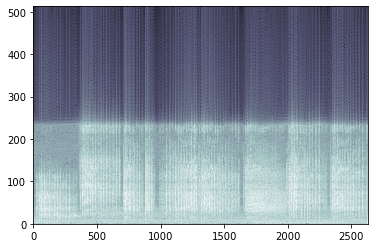

In [11]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
cmap=plt.cm.bone
cmap.set_under(color='k', alpha=None)
plt.pcolormesh(np.log10(data_spectrograms[5][2][2]),cmap=cmap)

## Plot binned spectrograms

C:\Users\Timmy\AppData\Local\Temp\ipykernel_3752\151632982.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("bone").copy()
  cmap.set_under(color='k', alpha=None)


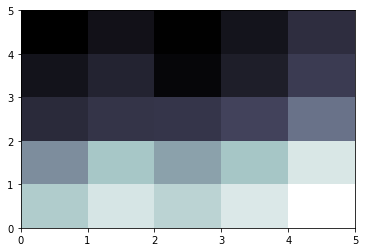

In [15]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
cmap=plt.cm.bone
cmap.set_under(color='k', alpha=None)
plt.pcolormesh(np.log10(data_spectrograms_binned[5][2][2]),cmap=cmap)